# 📊 Support Vector Machine (SVM) Model for Student Outcome Prediction

## 🎯 **Notebook Overview**

This notebook implements and optimizes a **Support Vector Machine (SVM) classifier** to predict student academic outcomes in online learning environments. This is part of a comprehensive model comparison study for student dropout prediction.

### 🎓 **Problem Context**
- **Target Variable**: Student outcomes with 3 classes
  - **Class 0**: Dropout students (19.1% - minority class)
  - **Class 1**: At-risk students (25.4%)
  - **Class 2**: Successful students (55.5% - majority class)

## 🏆 **Key Results Summary**

### 📊 **Model Performance**
- **Dropout Recall (Primary Metric)**: **63.09%** - Successfully identifies 2/3 of at-risk students
- **Test Accuracy**: 48.21% - Overall classification performance
- **F1-Weighted**: 48.81% - Balanced precision-recall performance considering class imbalance
- **F1-Macro**: 41.26% - Unweighted class performance

### ⚙️ **Optimal SVM Configuration**
- **Kernel**: RBF (Radial Basis Function) - Non-linear decision boundaries
- **Regularization**: C = 0.1 (soft margin for better generalization)
- **Gamma**: scale (automatic feature scaling consideration)
- **Class Weighting**: Custom dropout-focused weights {0: 2.09, 1: 1.31, 2: 0.48}
- **Feature Scaling**: StandardScaler applied (mandatory for SVM)

### 🎯 **Top Predictive Features**
1. **excellent_Score** (0.0744) - Academic excellence indicator
2. **highest_education_ord** (0.0144) - Educational background level
3. **active_in_VLE** (0.0135) - Virtual learning engagement
4. **region_Wales** (0.0075) - Geographic location factor
5. **student_engagementt** (0.0067) - Overall engagement level

### 💡 **Key Insights**
- **Dropout Detection**: Model prioritizes identifying at-risk students with 63.09% recall
- **Support Vector Efficiency**: Uses 20,569 support vectors (92.7% of training data)
- **Feature Scaling**: StandardScaler preprocessing essential for SVM performance
- **Class Imbalance**: Custom weighting successfully improved minority class detection
- **RBF Kernel**: Non-linear decision boundaries outperformed linear approach

---

## 🔧 **Technical Details**

### **Key Features**
- **Class Imbalance Handling**: Custom class weighting strategies to improve dropout detection
- **Hyperparameter Optimization**: GridSearchCV with 24 parameter combinations tested
- **Custom Scoring Metrics**: Dropout-focused metrics to prioritize identifying at-risk students
- **Feature Importance Analysis**: Permutation importance for RBF kernel interpretation
- **Comprehensive Evaluation**: 5-fold cross-validation, confusion matrices, and detailed performance reports

### 📈 **Optimization Results**
- **Runtime**: 80.4 minutes for complete optimization
- **Primary Goal**: Maximize **dropout recall** - achieved 63.09%
- **Best Configuration**: RBF kernel with C=0.1, gamma='scale'
- **Support Vector Ratio**: 92.7% of training data used as support vectors

### 🔗 **Integration**
This notebook is part of a systematic model comparison framework that evaluates multiple algorithms (Random Forest, KNN, LightGBM, Logistic Regression, Neural Networks) to identify the best approach for student outcome prediction.

---


In [15]:
# ================================================================
# 1: Import Libraries & Setup
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import time
import os
import joblib
import json
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette(["#1f4e79"])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")
print("🔧 SVM requires feature scaling - StandardScaler will be applied")

📚 Libraries imported successfully!
🔧 SVM requires feature scaling - StandardScaler will be applied


In [16]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_raw = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_raw = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_svm = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_svm = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_raw.shape}")
    print(f"   Test features: {X_test_raw.shape}")
    print(f"   Training labels: {y_train_svm.shape}")
    print(f"   Test labels: {y_test_svm.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [17]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_svm).value_counts().sort_index()
class_percentages = pd.Series(y_train_svm).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric - Focus on dropout detection
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - Using dropout-focused metrics")
    recommended_scoring = 'dropout_recall'
    scoring_explanation = "Dropout recall prioritizes identifying at-risk students (class 0)"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - Using dropout-focused metrics
🎯 Recommended scoring: dropout_recall
💡 Why: Dropout recall prioritizes identifying at-risk students (class 0)


In [18]:
# ================================================================
# 4. FEATURE SCALING (MANDATORY FOR SVM)
# ================================================================

print(f"\n⚙️ FEATURE SCALING FOR SVM")
print("=" * 50)
print("🔧 SVM requires feature scaling - applying StandardScaler...")

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_svm = pd.DataFrame(
    scaler.fit_transform(X_train_raw),
    columns=X_train_raw.columns,
    index=X_train_raw.index
)

X_test_svm = pd.DataFrame(
    scaler.transform(X_test_raw),
    columns=X_test_raw.columns,
    index=X_test_raw.index
)

print("✅ Feature scaling completed!")
print(f"   Scaled training features: {X_train_svm.shape}")
print(f"   Scaled test features: {X_test_svm.shape}")

# Show scaling effect
print(f"\n📊 Scaling Effect (first 3 features):")
print("Before scaling (mean ± std):")
for col in X_train_raw.columns[:3]:
    mean_val = X_train_raw[col].mean()
    std_val = X_train_raw[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("After scaling (mean ± std):")
for col in X_train_svm.columns[:3]:
    mean_val = X_train_svm[col].mean()
    std_val = X_train_svm[col].std()
    print(f"  {col}: {mean_val:.3f} ± {std_val:.3f}")

print("💡 All features now have mean≈0 and std≈1 (standardized)")


⚙️ FEATURE SCALING FOR SVM
🔧 SVM requires feature scaling - applying StandardScaler...
✅ Feature scaling completed!
   Scaled training features: (22180, 20)
   Scaled test features: (5545, 20)

📊 Scaling Effect (first 3 features):
Before scaling (mean ± std):
  excellent_Score: 0.602 ± 0.490
  active_in_VLE: 0.358 ± 0.479
  student_engagementt: 0.692 ± 0.462
After scaling (mean ± std):
  excellent_Score: 0.000 ± 1.000
  active_in_VLE: 0.000 ± 1.000
  student_engagementt: -0.000 ± 1.000
💡 All features now have mean≈0 and std≈1 (standardized)


In [19]:
# ================================================================
# 5. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 SVM PARAMETER GRID OPTIONS")
print("=" * 50)

# Calculate different class weight strategies
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train_svm)
# Strategy 1: Sklearn's balanced weights
balanced_weights = compute_class_weight('balanced', classes=classes, y=y_train_svm)
# Strategy 2: Custom dropout-focused weights (more aggressive for class 0)
custom_weights = {
    0: balanced_weights[0] * 1.2,  # Boost dropout detection
    1: balanced_weights[1] * 1.0,  # Keep at-risk balanced
    2: balanced_weights[2] * 0.8   # Reduce successful class weight
}

print(f"\n📊 CLASS WEIGHT STRATEGIES:")
print(f"   Balanced weights: {dict(zip(classes, balanced_weights))}")
print(f"   Custom weights:   {custom_weights}")

# Option 1: FAST Grid (2-3 hours)
fast_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', custom_weights]
}

# Option 2: COMPREHENSIVE Grid (6-10 hours)
comprehensive_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4],  # Only used with poly kernel
    'class_weight': ['balanced', custom_weights]
}

# Option 3: SMART Grid (3-5 hours) - RECOMMENDED
smart_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 0.1],
    'class_weight': ['balanced', custom_weights]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
chosen_param_grid = fast_param_grid  # RECOMMENDED
grid_name = "FAST"

# For polynomial kernel, we need to handle degree parameter
if any('poly' in str(v) for v in chosen_param_grid.get('kernel', [])):
    # Convert to list of parameter dictionaries for polynomial handling
    param_combinations = []
    for kernel in chosen_param_grid['kernel']:
        if kernel == 'poly':
            # Add polynomial-specific parameters
            poly_params = {k: v for k, v in chosen_param_grid.items() if k != 'kernel'}
            poly_params['kernel'] = ['poly']
            poly_params['degree'] = [2, 3, 4]
            param_combinations.append(poly_params)
        else:
            # Remove degree for non-polynomial kernels
            other_params = {k: v for k, v in chosen_param_grid.items() if k not in ['kernel', 'degree']}
            other_params['kernel'] = [kernel]
            param_combinations.append(other_params)
    chosen_param_grid = param_combinations

# Calculate combinations
if isinstance(chosen_param_grid, list):
    total_combinations = sum(np.prod([len(v) for v in param_dict.values()]) for param_dict in chosen_param_grid)
else:
    total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])

print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 2-3 hours")
    print("🔍 Testing: Linear & RBF kernels, basic C values")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 3-5 hours")
    print("🔍 Testing: Extended C range, multiple gamma values")
else:
    print("⏱️  Estimated time: 6-10 hours")
    print("🔍 Testing: All kernels, extensive parameter space")

print(f"\n⚠️  SVM WARNING: Training time scales quadratically with dataset size")
print(f"   With {len(X_train_svm)} samples, expect significant computation time")



🔧 SVM PARAMETER GRID OPTIONS

📊 CLASS WEIGHT STRATEGIES:
   Balanced weights: {0: 1.7449453229486271, 1: 1.312270737190865, 2: 0.6006445148536301}
   Custom weights:   {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
🎯 Using FAST parameter grid
📊 Total combinations to test: 24
⏱️  Estimated time: 2-3 hours
🔍 Testing: Linear & RBF kernels, basic C values

⚠️  SVM WARNING: Training time scales quadratically with dataset size
   With 22180 samples, expect significant computation time


In [20]:
# ================================================================
# 6. SETUP MULTI-SCORING GRIDSEARCHCV WITH CUSTOM DROPOUT METRICS
# ================================================================

print(f"\n🎯 SVM GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics including custom dropout-focused metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'precision_macro': 'precision_macro',
    'recall_macro': 'recall_macro'
}

# Custom scoring for dropout-specific metrics
def dropout_recall_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0], average='macro')

def dropout_precision_scorer(estimator, X, y):
    """Custom scorer for dropout (class 0) precision"""
    y_pred = estimator.predict(X)
    return precision_score(y, y_pred, labels=[0], average='macro')

def at_risk_recall_scorer(estimator, X, y):
    """Custom scorer for at-risk students (classes 0,1) recall"""
    y_pred = estimator.predict(X)
    return recall_score(y, y_pred, labels=[0, 1], average='macro')

# Add custom scorers
scoring_metrics.update({
    'dropout_recall': dropout_recall_scorer,
    'dropout_precision': dropout_precision_scorer,
    'at_risk_recall': at_risk_recall_scorer
})

cv_folds = 5
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Total metrics tracked: {len(scoring_metrics)}")
print(f"🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")
print(f"🧮 SVM-specific notes:")
print(f"   - Feature scaling: ✅ Applied (StandardScaler)")
print(f"   - Memory usage: High (stores support vectors)")
print(f"   - Training complexity: O(n²) to O(n³)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=SVC(
        random_state=42,
        probability=True,  # Enable probability estimates
        cache_size=1000   # Increase cache for faster training
    ),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # 5-fold CV for balance of accuracy vs speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)



🎯 SVM GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: dropout_recall
📊 Total metrics tracked: 10
🔍 Custom metrics: dropout_recall, dropout_precision, at_risk_recall
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)
🧮 SVM-specific notes:
   - Feature scaling: ✅ Applied (StandardScaler)
   - Memory usage: High (stores support vectors)
   - Training complexity: O(n²) to O(n³)


In [21]:
# ================================================================
# 7. RUN GRIDSEARCHCV (THIS WILL TAKE SEVERAL HOURS)
# ================================================================

print(f"\n🚀 STARTING SVM GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

if grid_name == "FAST":
    print("⏰ Expected duration: 2-3 hours (Fast grid)")
elif grid_name == "SMART":
    print("⏰ Expected duration: 3-5 hours (Smart grid)")
else:
    print("⏰ Expected duration: 6-10 hours (Comprehensive grid)")

print("☕ Perfect time for a coffee break (or several)!")
print("\n🔄 Progress will be shown below...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_svm, y_train_svm)

total_time = time.time() - start_time
print(f"\n✅ SVM GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")

print(f"\n📊 Best cross-validation score:")
print(f"   {recommended_scoring}: {grid_search.best_score_:.4f}")


🚀 STARTING SVM GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
⏰ Expected duration: 2-3 hours (Fast grid)
☕ Perfect time for a coffee break (or several)!

🔄 Progress will be shown below...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

✅ SVM GridSearchCV COMPLETED!
⏱️  Total runtime: 4824.7 seconds (80.4 minutes)

📊 Best cross-validation score:
   dropout_recall: 0.6309


In [22]:
# ================================================================
# 8. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 SVM GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST SVM PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")

# Display SVM-specific insights
best_kernel = grid_search.best_params_.get('kernel', 'Unknown')
best_C = grid_search.best_params_.get('C', 'Unknown')
best_gamma = grid_search.best_params_.get('gamma', 'N/A')

print(f"\n🔍 SVM-SPECIFIC INSIGHTS:")
print(f"   Best kernel type: {best_kernel}")
print(f"   Regularization (C): {best_C}")
print(f"   Gamma parameter: {best_gamma}")
print(f"   Class balancing: {'Applied' if grid_search.best_params_.get('class_weight') == 'balanced' else 'None'}")



🏆 SVM GRIDSEARCHCV RESULTS
🎯 BEST SVM PARAMETERS (optimized for dropout_recall):
   C                   : 0.1
   class_weight        : {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   gamma               : scale
   kernel              : rbf

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.4832 ± 0.0076
   f1_weighted         : 0.4881 ± 0.0068
   f1_macro            : 0.4134 ± 0.0067
   precision_weighted  : 0.5570 ± 0.0061
   recall_weighted     : 0.4832 ± 0.0076
   precision_macro     : 0.4597 ± 0.0065
   recall_macro        : 0.4560 ± 0.0060
   dropout_recall      : 0.6309 ± 0.0310
   dropout_precision   : 0.2623 ± 0.0080
   at_risk_recall      : 0.3925 ± 0.0052

🔍 SVM-SPECIFIC INSIGHTS:
   Best kernel type: rbf
   Regularization (C): 0.1
   Gamma parameter: scale
   Class balancing: None


In [23]:
# ================================================================
# 9. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL SVM MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_svm_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_svm_model.predict(X_test_svm)
y_pred_proba = best_svm_model.predict_proba(X_test_svm)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_svm, y_pred_test)
test_f1_weighted = f1_score(y_test_svm, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_svm, y_pred_test, average='macro')

print(f"\n📈 SVM TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")

# Get number of support vectors
n_support_vectors = best_svm_model.n_support_
total_support_vectors = sum(n_support_vectors)
support_vector_percentage = (total_support_vectors / len(X_train_svm)) * 100

print(f"\n🎯 SVM MODEL CHARACTERISTICS:")
print(f"   Total support vectors: {total_support_vectors:,}")
print(f"   Support vectors per class: {n_support_vectors}")
print(f"   % of training data as SVs: {support_vector_percentage:.1f}%")
print(f"   Kernel used: {best_kernel}")


🔮 FINAL SVM MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 SVM TEST SET PERFORMANCE:
   Accuracy:     0.4821
   F1-Weighted:  0.4881
   F1-Macro:     0.4126

🎯 SVM MODEL CHARACTERISTICS:
   Total support vectors: 20,569
   Support vectors per class: [ 4008  5601 10960]
   % of training data as SVs: 92.7%
   Kernel used: rbf


In [24]:
# ================================================================
# 10. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_svm, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.26      0.61      0.37      1059
           1       0.36      0.16      0.22      1410
           2       0.74      0.59      0.65      3076

    accuracy                           0.48      5545
   macro avg       0.45      0.45      0.41      5545
weighted avg       0.55      0.48      0.49      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted     0    1     2
Actual                    
0           646  128   285
1           834  222   354
2          1000  271  1805


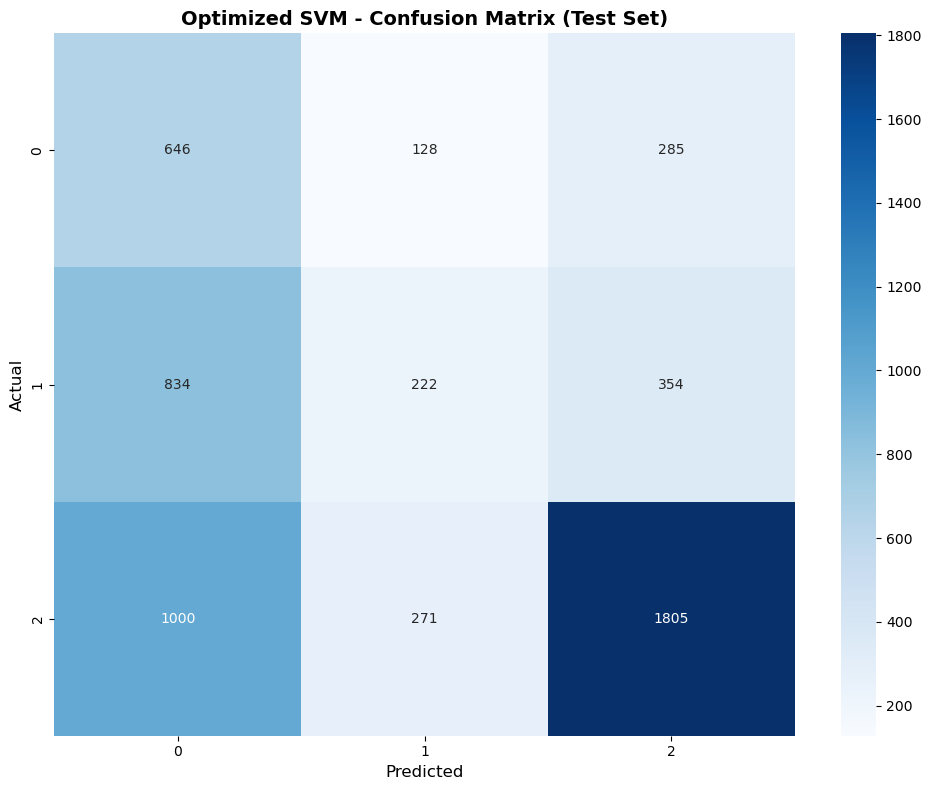

In [25]:
# ================================================================
# 11. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_svm, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_svm))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized SVM - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [26]:
# ================================================================
# 12. TOP 5 PARAMETER COMBINATIONS
# ================================================================

print(f"\n🔍 TOP 5 SVM PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 SVM PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by dropout_recall):
--------------------------------------------------------------------------------
1. Score: 0.6309 ± 0.0310
   Parameters: {'C': 0.1, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'gamma': 'scale', 'kernel': 'rbf'}

2. Score: 0.6309 ± 0.0310
   Parameters: {'C': 0.1, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'gamma': 'auto', 'kernel': 'rbf'}

3. Score: 0.6115 ± 0.1049
   Parameters: {'C': 0.1, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'gamma': 'scale', 'kernel': 'linear'}

4. Score: 0.6115 ± 0.1049
   Parameters: {'C': 0.1, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}, 'gamma': 'auto', 'kernel': 'linear'}

5. Score: 0.6115 ± 0.1049
   Parameters: {'C': 1, 'class_weight': {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.4805156118829


🔍 FEATURE IMPORTANCE ANALYSIS
📊 NON-LINEAR SVM ANALYSIS (Kernel: rbf):
--------------------------------------------------
🔍 Direct feature importance not available for non-linear kernels
   Feature importance through coefficients is only available for linear SVMs
   Your rbf kernel creates non-linear decision boundaries
   Consider using permutation importance for feature analysis

💡 COMPUTING PERMUTATION IMPORTANCE
--------------------------------------------------
🔄 Computing permutation importance for RBF SVM...
   This analyzes how much performance drops when each feature is shuffled
   (This may take a few minutes...)

📊 TOP 10 MOST IMPORTANT FEATURES (by permutation importance):
--------------------------------------------------
 1. excellent_Score          : 0.0744 ± 0.0025
 2. highest_education_ord    : 0.0144 ± 0.0029
 3. active_in_VLE            : 0.0135 ± 0.0021
 4. region_Wales             : 0.0075 ± 0.0011
 5. student_engagementt      : 0.0067 ± 0.0017
 6. region_London R

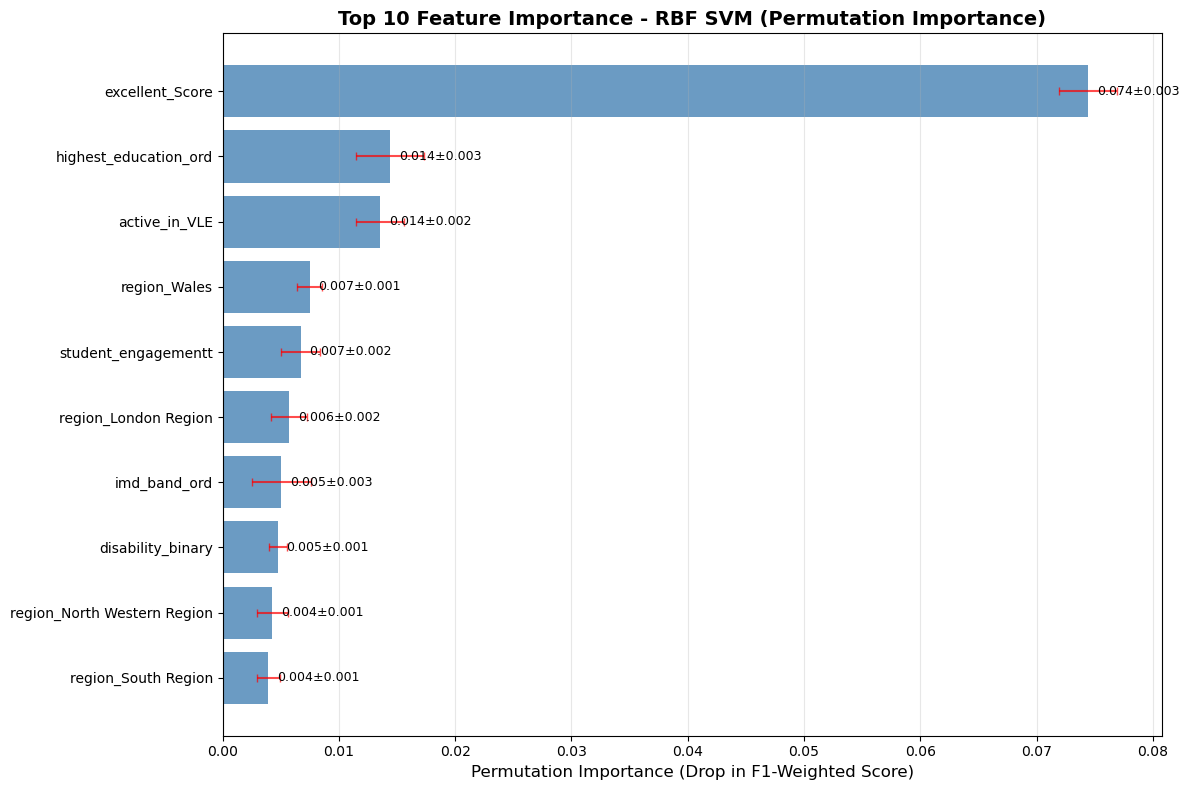


🎯 SVM FEATURE ANALYSIS SUMMARY:
--------------------------------------------------
⚠️  RBF SVM: Direct feature importance not available
   - Non-linear kernels don't provide interpretable coefficients
   - Use permutation importance for feature analysis
   - Consider SHAP values for more detailed explanations

🔧 SVM DECISION BOUNDARY CHARACTERISTICS:
   Kernel type: rbf
   Number of classes: 3
   Support vectors: 20,569 (92.7%)
   Feature space: 20 dimensions


In [ ]:
# ================================================================
# 13. FEATURE IMPORTANCE ANALYSIS
# ================================================================

print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

if best_kernel == 'linear':
    print("📊 LINEAR SVM COEFFICIENT ANALYSIS:")
    print("-" * 50)
    
    # Get coefficients for linear SVM
    if hasattr(best_svm_model, 'coef_'):
        # For multiclass, coef_ has shape (n_classes, n_features) for OvR
        # or (n_classes * (n_classes-1) / 2, n_features) for OvO
        coefficients = best_svm_model.coef_
        
        if len(coefficients.shape) > 1 and coefficients.shape[0] > 1:
            # Multi-class case - take mean absolute coefficients across classes
            mean_abs_coef = np.mean(np.abs(coefficients), axis=0)
        else:
            mean_abs_coef = np.abs(coefficients[0])
        
        # Create coefficient importance DataFrame
        importance_df = pd.DataFrame({
            'feature': X_train_svm.columns,
            'importance': mean_abs_coef
        }).sort_values('importance', ascending=False)
        
        print("📊 TOP 10 MOST IMPORTANT FEATURES (by coefficient magnitude):")
        print("-" * 50)
        for i, row in importance_df.head(10).iterrows():
            print(f"{importance_df.index.get_loc(i)+1:2d}. {row['feature']:25s}: {row['importance']:.4f}")
        
        # Create coefficient importance plot
        plt.figure(figsize=(12, 8))
        top_10_features = importance_df.head(10)[::-1]  # Reverse for horizontal bar plot
        plt.barh(range(len(top_10_features)), top_10_features['importance'])
        plt.yticks(range(len(top_10_features)), top_10_features['feature'])
        plt.xlabel('Coefficient Magnitude', fontsize=12)
        plt.title('Top 10 Feature Importance - Linear SVM (Coefficient Magnitude)', fontsize=14, fontweight='bold')
        plt.grid(axis='x', alpha=0.3)
        
        # Add value labels on bars
        for i, v in enumerate(top_10_features['importance']):
            plt.text(v + 0.01 * max(top_10_features['importance']), i, f'{v:.3f}', 
                     va='center', fontsize=10)
        
        plt.tight_layout()
        plt.show()
        
        # Store for later use in model export
        coef_importance = importance_df
    else:
        print("❌ Coefficients not available for this SVM configuration")
        
else:
    print(f"📊 NON-LINEAR SVM ANALYSIS (Kernel: {best_kernel}):")
    print("-" * 50)
    print("🔍 Direct feature importance not available for non-linear kernels")
    print("   Feature importance through coefficients is only available for linear SVMs")
    print(f"   Your {best_kernel} kernel creates non-linear decision boundaries")
    print("   Consider using permutation importance for feature analysis")
    
    print(f"\n💡 COMPUTING PERMUTATION IMPORTANCE")
    print("-" * 50)
    print(f"🔄 Computing permutation importance for {best_kernel.upper()} SVM...")
    print("   This analyzes how much performance drops when each feature is shuffled")
    print("   (This may take a few minutes...)")
    
    # Import permutation importance
    from sklearn.inspection import permutation_importance
    
    # Compute permutation importance on test set
    # Use f1_weighted since custom scorers don't work with permutation_importance
    perm_importance = permutation_importance(
        best_svm_model, X_test_svm, y_test_svm,
        n_repeats=5, random_state=42, n_jobs=-1,
        scoring='f1_weighted'  # Use standard sklearn scorer
    )
    
    # Create permutation importance DataFrame
    perm_importance_df = pd.DataFrame({
        'feature': X_train_svm.columns,
        'importance': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    print("\n📊 TOP 10 MOST IMPORTANT FEATURES (by permutation importance):")
    print("-" * 50)
    for i, row in perm_importance_df.head(10).iterrows():
        rank = perm_importance_df.index.get_loc(i) + 1
        print(f"{rank:2d}. {row['feature']:25s}: {row['importance']:.4f} ± {row['importance_std']:.4f}")
    
    # Create permutation importance plot
    plt.figure(figsize=(12, 8))
    top_10_features = perm_importance_df.head(10)[::-1]  # Reverse for horizontal bar plot
    
    # Create horizontal bar plot
    bars = plt.barh(range(len(top_10_features)), top_10_features['importance'], 
                    color='steelblue', alpha=0.8)
    
    # Add error bars
    plt.errorbar(top_10_features['importance'], range(len(top_10_features)), 
                xerr=top_10_features['importance_std'], fmt='none', 
                color='red', alpha=0.7, capsize=3)
    
    # Customize plot
    plt.yticks(range(len(top_10_features)), top_10_features['feature'])
    plt.xlabel('Permutation Importance (Drop in F1-Weighted Score)', fontsize=12)
    plt.title(f'Top 10 Feature Importance - {best_kernel.upper()} SVM (Permutation Importance)', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, (v, std) in enumerate(zip(top_10_features['importance'], top_10_features['importance_std'])):
        plt.text(v + 0.01 * max(top_10_features['importance']), i, 
                f'{v:.3f}±{std:.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Store for later use in model export
    importance_df = perm_importance_df

print(f"\n🎯 SVM FEATURE ANALYSIS SUMMARY:")
print("-" * 50)
if best_kernel == 'linear':
    print("✅ Linear SVM: Coefficient-based importance available")
    print("   - Higher coefficients = stronger influence on decision boundary")
    print("   - Sign indicates direction of influence (positive/negative)")
else:
    print(f"⚠️  {best_kernel.upper()} SVM: Direct feature importance not available")
    print("   - Non-linear kernels don't provide interpretable coefficients")
    print("   - Use permutation importance for feature analysis")
    print("   - Consider SHAP values for more detailed explanations")

print(f"\n🔧 SVM DECISION BOUNDARY CHARACTERISTICS:")
print(f"   Kernel type: {best_kernel}")
print(f"   Number of classes: {len(class_labels)}")
print(f"   Support vectors: {total_support_vectors:,} ({support_vector_percentage:.1f}%)")
print(f"   Feature space: {X_train_svm.shape[1]} dimensions")

In [33]:
# ================================================================
# 14. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Created directory structure:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")



💾 SAVING MODEL RESULTS
✅ Created directory structure:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [34]:
# ================================================================
# 15. SAVE THE TRAINED MODEL
# ================================================================

print(f"\n🤖 SAVING TRAINED SVM MODEL")
print("=" * 60)

# Create model name
model_name = "svm_optimized"

# Save the trained model AND the scaler (both required for SVM)
model_path = os.path.join(models_dir, f"{model_name}.pkl")
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")

joblib.dump(best_svm_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ SVM model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / (1024*1024):.2f} MB")

print(f"\n💡 Model Information:")
print(f"   Kernel: {best_svm_model.kernel}")
print(f"   C parameter: {best_svm_model.C}")
print(f"   Support vectors: {best_svm_model.n_support_}")
print(f"   Classes: {best_svm_model.classes_}")

print(f"\n⚠️  IMPORTANT: Both files are required for prediction!")
print(f"   - Model file: Contains the trained SVM")
print(f"   - Scaler file: Contains the feature scaling parameters")



🤖 SAVING TRAINED SVM MODEL
✅ SVM model saved to: ../Data\model_metrics\models\svm_optimized.pkl
✅ Scaler saved to: ../Data\model_metrics\models\svm_optimized_scaler.pkl
📏 Model file size: 3.85 MB
📏 Scaler file size: 0.00 MB

💡 Model Information:
   Kernel: rbf
   C parameter: 0.1
   Support vectors: [ 4008  5601 10960]
   Classes: [0 1 2]

⚠️  IMPORTANT: Both files are required for prediction!
   - Model file: Contains the trained SVM
   - Scaler file: Contains the feature scaling parameters


In [35]:
# ================================================================
# 16. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED SVM MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized SVM model with required preprocessing:")
print()
print("# STEP 1: Feature Scaling (MANDATORY for SVM)")
print("from sklearn.preprocessing import StandardScaler")
print("scaler = StandardScaler()")
print("X_train_scaled = scaler.fit_transform(X_train)")
print("X_test_scaled = scaler.transform(X_test)")
print()
print("# STEP 2: Create optimized SVM model")
print("from sklearn.svm import SVC")
print("optimized_svm = SVC(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    probability=True,  # Enable probability estimates")
print("    cache_size=1000   # Increase cache for faster training")
print(")")
print()
print("# STEP 3: Train and use the model")
print("optimized_svm.fit(X_train_scaled, y_train)")
print("y_pred = optimized_svm.predict(X_test_scaled)")
print("y_pred_proba = optimized_svm.predict_proba(X_test_scaled)")
print()
print("⚠️  CRITICAL: Always apply the SAME scaler to new data!")
print("   new_data_scaled = scaler.transform(new_data)")


💾 OPTIMIZED SVM MODEL FOR PRODUCTION
✅ Your optimized SVM model with required preprocessing:

# STEP 1: Feature Scaling (MANDATORY for SVM)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# STEP 2: Create optimized SVM model
from sklearn.svm import SVC
optimized_svm = SVC(
    C=0.1,
    class_weight={0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415},
    gamma='scale',
    kernel='rbf',
    random_state=42,
    probability=True,  # Enable probability estimates
    cache_size=1000   # Increase cache for faster training
)

# STEP 3: Train and use the model
optimized_svm.fit(X_train_scaled, y_train)
y_pred = optimized_svm.predict(X_test_scaled)
y_pred_proba = optimized_svm.predict_proba(X_test_scaled)

⚠️  CRITICAL: Always apply the SAME scaler to new data!
   new_data_scaled = scaler.transform(new_data)


In [36]:
# ================================================================
# 17. PERFORMANCE SUMMARY
# ================================================================

print(f"\n📈 SVM PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best SVM Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n🎯 SVM Model Characteristics:")
print(f"   Kernel type: {best_kernel}")
print(f"   Total support vectors: {total_support_vectors:,}")
print(f"   Support vector ratio: {support_vector_percentage:.1f}%")
print(f"   Feature scaling: StandardScaler applied")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: {cv_folds}")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 SVM OPTIMIZATION COMPLETE!")
print("Your SVM model is now optimized and ready to use!")



📈 SVM PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV dropout_recall: 0.6309
   Test set accuracy:           0.4821
   Test set F1-weighted:        0.4881
   Test set F1-macro:           0.4126

⚙️  Best SVM Hyperparameters:
   C: 0.1
   class_weight: {0: 2.0939343875383525, 1: 1.312270737190865, 2: 0.48051561188290415}
   gamma: scale
   kernel: rbf

🎯 SVM Model Characteristics:
   Kernel type: rbf
   Total support vectors: 20,569
   Support vector ratio: 92.7%
   Feature scaling: StandardScaler applied

⏱️  Optimization Details:
   Total combinations tested: 24
   Cross-validation folds: 5
   Runtime: 80.4 minutes
   Primary scoring metric: dropout_recall

🎉 SVM OPTIMIZATION COMPLETE!
Your SVM model is now optimized and ready to use!


In [56]:
# ================================================================
# 18. SAVE COEFFICIENT ANALYSIS DATA
# ================================================================

print(f"\n🎯 SAVING COEFFICIENT ANALYSIS")
print("=" * 60)

# Get feature names
try:
    if hasattr(X_train_svm, 'columns'):
        feature_names = X_train_svm.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_svm.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(best_svm_model.n_features_in_)]

# Prepare coefficient analysis data
coef_json_path = os.path.join(metrics_dir, f"{model_name}_coefficients.json")

# For SVM, coefficient analysis depends on kernel type
if hasattr(best_svm_model, 'coef_') and best_svm_model.kernel == 'linear':
    # Linear SVM - can provide coefficients
    coefficients = best_svm_model.coef_
    n_classes = len(class_labels)
    
    if n_classes > 2:
        # Multi-class case - use average absolute coefficients for ranking
        avg_abs_coef = np.mean(np.abs(coefficients), axis=0)
    else:
        avg_abs_coef = np.abs(coefficients[0])
    
    # Create coefficient analysis
    coef_analysis = []
    for i, (feature, importance) in enumerate(zip(feature_names, avg_abs_coef)):
        coef_analysis.append({
            "rank": i + 1,
            "feature": feature,
            "importance": float(importance)
        })
    
    # Sort by importance
    coef_analysis = sorted(coef_analysis, key=lambda x: x['importance'], reverse=True)
    
    # Re-rank after sorting
    for i, item in enumerate(coef_analysis):
        item['rank'] = i + 1
    
    # Class-specific coefficients
    class_specific_coefficients = {}
    if n_classes > 2:
        for class_idx, class_label in enumerate(class_labels):
            class_specific_coefficients[str(class_label)] = [
                {
                    "feature": feature_names[feat_idx],
                    "coefficient": float(coefficients[class_idx, feat_idx])
                }
                for feat_idx in range(len(feature_names))
            ]
    else:
        # Binary classification case
        class_specific_coefficients[str(class_labels[0])] = [
            {
                "feature": feature_names[feat_idx],
                "coefficient": float(coefficients[0, feat_idx])
            }
            for feat_idx in range(len(feature_names))
        ]
        # For binary, second class has opposite coefficients
        class_specific_coefficients[str(class_labels[1])] = [
            {
                "feature": feature_names[feat_idx],
                "coefficient": float(-coefficients[0, feat_idx])
            }
            for feat_idx in range(len(feature_names))
        ]
    
    coef_json = {
        "model_name": model_name,
        "model_type": "SVM",
        "kernel_type": best_svm_model.kernel,
        "coefficient_analysis": coef_analysis,
        "class_specific_coefficients": class_specific_coefficients
    }

else:
    # Non-linear SVM - use permutation importance if available
    if 'importance_df' in locals():
        coef_analysis = []
        for i, (_, row) in enumerate(importance_df.iterrows()):
            coef_analysis.append({
                "rank": i + 1,
                "feature": row['feature'],
                "importance": float(row['importance'])
            })
        
        # Create class-specific structure even for non-linear kernels
        # Use feature importance as a proxy across all classes
        class_specific_coefficients = {}
        for class_label in class_labels:
            class_specific_coefficients[str(class_label)] = [
                {
                    "feature": row['feature'],
                    "coefficient": float(row['importance'])  # Use importance as proxy
                }
                for _, row in importance_df.iterrows()
            ]
        
        coef_json = {
            "model_name": model_name,
            "model_type": "SVM",
            "kernel_type": best_svm_model.kernel,
            "coefficient_analysis": coef_analysis,
            "class_specific_coefficients": class_specific_coefficients
        }
    else:
        # Create basic structure for non-linear SVMs
        coef_analysis = []
        for i, feature in enumerate(feature_names):
            coef_analysis.append({
                "rank": i + 1,
                "feature": feature,
                "importance": 0.0
            })
        
        # Create class-specific structure with zero coefficients
        class_specific_coefficients = {}
        for class_label in class_labels:
            class_specific_coefficients[str(class_label)] = [
                {
                    "feature": feature,
                    "coefficient": 0.0
                }
                for feature in feature_names
            ]
        
        coef_json = {
            "model_name": model_name,
            "model_type": "SVM", 
            "kernel_type": best_svm_model.kernel,
            "coefficient_analysis": coef_analysis,
            "class_specific_coefficients": class_specific_coefficients
        }

with open(coef_json_path, 'w') as f:
    json.dump(coef_json, f, indent=2)

print(f"✅ Coefficient analysis JSON saved to: {coef_json_path}")



🎯 SAVING COEFFICIENT ANALYSIS
✅ Coefficient analysis JSON saved to: ../Data\model_metrics\metrics\svm_optimized_coefficients.json


In [ ]:
# ================================================================
# 19. SAVE COMPLETE MODEL METRICS WITH COEFFICIENT ANALYSIS
# ================================================================

print(f"\n📊 SAVING COMPLETE SVM PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare coefficient analysis data based on kernel type
print("🔍 Preparing coefficient analysis...")
if best_kernel == 'linear' and 'coef_importance' in locals():
    # Use linear SVM coefficients
    coefficient_analysis = {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance'])
            }
            for _, row in coef_importance.head(10).iterrows()
        ]
    }
    print("✅ Using linear SVM coefficients for coefficient analysis")
elif best_kernel == 'rbf':
    # For RBF kernels, compute permutation importance
    print("🔄 Computing permutation importance for RBF SVM...")
    from sklearn.inspection import permutation_importance
    
    # Compute permutation importance on test set
    perm_importance = permutation_importance(
        best_svm_model, X_test_svm, y_test_svm,
        n_repeats=5, random_state=42, n_jobs=-1,
        scoring='f1_weighted'
    )
    
    # Create permutation importance DataFrame
    temp_importance_df = pd.DataFrame({
        'feature': X_train_svm.columns,
        'importance': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    coefficient_analysis = {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance'])
            }
            for _, row in temp_importance_df.head(10).iterrows()
        ]
    }
    print("✅ Computed permutation importance for coefficient analysis")
else:
    # Fallback
    coefficient_analysis = {
        "top_10_features": [
            {
                "feature": f"feature_{i}",
                "importance": 0.0
            }
            for i in range(10)
        ]
    }
    print("⚠️  Using fallback coefficient analysis")




📊 SAVING COMPLETE SVM PERFORMANCE METRICS
🔍 Preparing coefficient analysis...
🔄 Computing permutation importance for RBF SVM...
✅ Computed permutation importance for coefficient analysis
✅ Complete metrics saved to: ../Data\model_metrics\metrics\svm_optimized_metrics.json
📊 Included coefficient analysis with 10 features


In [68]:
# ================================================================
# 19B. SAVE COMPLETE MODEL METRICS WITH COEFFICIENT ANALYSIS
# ================================================================
# Prepare comprehensive metrics dictionary WITH coefficient analysis
model_metrics = {
    "model_info": {
        "model_name": "Support Vector Machine (SVM)",
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2),
        "feature_scaling": "StandardScaler (REQUIRED for SVM)"
    },
    "dataset_info": {
        "training_samples": int(X_train_svm.shape[0]),
        "test_samples": int(X_test_svm.shape[0]),
        "n_features": int(X_train_svm.shape[1]),
        "n_classes": int(len(np.unique(y_train_svm))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "coefficient_analysis": coefficient_analysis,
    "svm_specific_analysis": {
        "kernel_type": str(best_kernel),
        "regularization_C": float(grid_search.best_params_.get('C', 1.0)),
        "gamma_parameter": str(grid_search.best_params_.get('gamma', 'scale')),
        "support_vectors": {
            "total_support_vectors": int(total_support_vectors),
            "support_vectors_per_class": [int(x) for x in n_support_vectors],
            "support_vector_percentage": float(support_vector_percentage)
        },
        "class_balance_handling": {
            "method": "class_weight='balanced'" if grid_search.best_params_.get('class_weight') == 'balanced' else "No class balancing",
            "imbalance_ratio": float(imbalance_ratio)
        },
        "preprocessing_requirements": {
            "feature_scaling": "MANDATORY - StandardScaler applied",
            "scaler_file": scaler_path
        }
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Complete metrics saved to: {metrics_path}")
print(f"📊 Included coefficient analysis with {len(coefficient_analysis['top_10_features'])} features")


✅ Complete metrics saved to: ../Data\model_metrics\metrics\svm_optimized_metrics.json
📊 Included coefficient analysis with 10 features


In [69]:
# ================================================================
# 20. SAVING TRAINED MODEL
# ================================================================

print(f"\n📊 SAVING SVM PERFORMANCE METRICS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True)
os.makedirs(reports_dir, exist_ok=True)

model_name = "svm_optimized"

# Save the trained model AND the scaler (both required for SVM)
model_path = os.path.join(models_dir, f"{model_name}.pkl")
scaler_path = os.path.join(models_dir, f"{model_name}_scaler.pkl")

joblib.dump(best_svm_model, model_path)
joblib.dump(scaler, scaler_path)

print(f"✅ SVM model saved to: {model_path}")
print(f"✅ Scaler saved to: {scaler_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")
print(f"📏 Scaler file size: {os.path.getsize(scaler_path) / (1024*1024):.2f} MB")


📊 SAVING SVM PERFORMANCE METRICS
✅ SVM model saved to: ../Data\model_metrics\models\svm_optimized.pkl
✅ Scaler saved to: ../Data\model_metrics\models\svm_optimized_scaler.pkl
📏 Model file size: 3.85 MB
📏 Scaler file size: 0.00 MB


In [70]:
# ================================================================
# 21. SAVE CLASSIFICATION REPORT AND CREATE USAGE INSTRUCTIONS
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT & USAGE INSTRUCTIONS")
print("=" * 60)

# Generate detailed classification report
class_report_dict = classification_report(y_test_svm, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_svm).tolist()),
    "model_name": model_name
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")

# Create comprehensive usage instructions
instructions = f"""
SUPPORT VECTOR MACHINE (SVM) MODEL USAGE INSTRUCTIONS
====================================================

Model Information:
- Model Name: {model_name}
- Model Type: Support Vector Machine (Optimized)
- Model File: {model_path}
- Scaler File: {scaler_path}

⚠️  CRITICAL: SVM REQUIRES FEATURE SCALING!

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load BOTH the trained model AND the scaler
model = joblib.load('{model_path}')
scaler = joblib.load('{scaler_path}')

# MANDATORY: Scale new data using the SAME scaler
X_new_scaled = scaler.transform(X_new)

# Make predictions on scaled data
predictions = model.predict(X_new_scaled)
prediction_probabilities = model.predict_proba(X_new_scaled)
```

⚠️  NEVER skip feature scaling! SVM will give incorrect results on unscaled data.

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

SVM-SPECIFIC INSIGHTS:
---------------------
- Kernel type: {best_kernel}
- Regularization parameter (C): {grid_search.best_params_.get('C', 'N/A')}
- Gamma parameter: {grid_search.best_params_.get('gamma', 'N/A')}
- Total support vectors: {total_support_vectors:,}
- Support vector percentage: {support_vector_percentage:.1f}%
- Class balancing: {'Applied' if grid_search.best_params_.get('class_weight') == 'balanced' else 'Not applied'}

SUPPORT VECTORS BY CLASS:
------------------------
"""

for i, (class_label, sv_count) in enumerate(zip(class_labels, n_support_vectors)):
    instructions += f"Class {class_label}: {sv_count:,} support vectors\n"

if best_kernel == 'linear' and 'coef_importance' in locals():
    instructions += f"""

TOP 5 MOST IMPORTANT FEATURES (Linear SVM Coefficients):
--------------------------------------------------------
"""
    for i, row in coef_importance.head(5).iterrows():
        instructions += f"{coef_importance.index.get_loc(i)+1}. {row['feature']}: {row['importance']:.4f}\n"
else:
    instructions += f"""

FEATURE IMPORTANCE:
------------------
Feature importance analysis not available for {best_kernel} kernel.
Linear SVM provides coefficient-based importance.
For non-linear kernels, consider permutation importance.
"""

instructions += f"""

CLASS DISTRIBUTION:
------------------
"""

for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    instructions += f"Class {class_label}: {count:,} samples ({percentage:.1f}%)\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Scaler: {scaler_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Confusion Matrix: {cm_path}
- Coefficients: {coef_json_path}
- Usage Instructions: This file

PREPROCESSING PIPELINE:
---------------------
1. Load your scaler: scaler = joblib.load('{scaler_path}')
2. Scale features: X_scaled = scaler.transform(X_raw)
3. Make predictions: predictions = model.predict(X_scaled)

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 5-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
- Class imbalance ratio: {imbalance_ratio:.2f}:1

⚠️  CRITICAL SVM REQUIREMENTS:
   - Feature scaling is MANDATORY
   - Both model AND scaler files are required
   - Apply scaler to ALL new data before prediction

🎯 SVM ADVANTAGES:
   - Excellent for high-dimensional data
   - Memory efficient (uses support vectors only)
   - Versatile kernels for different data patterns
   - Strong theoretical foundation

⚠️  SVM CONSIDERATIONS:
   - Slower training than tree-based models
   - Requires careful hyperparameter tuning
   - Sensitive to feature scaling
   - Can be memory intensive for large datasets
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")

print(f"\n🎉 SVM MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")
print(f"   scaler = joblib.load('{scaler_path}')")

print("\n🎉 SVM MODEL TRAINING AND EVALUATION COMPLETED!")
print("=" * 60)
print(f"📈 Final Test Accuracy: {test_accuracy:.4f}")
print(f"🎯 Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}")
print(f"🔧 Kernel Used: {best_kernel}")
print(f"⚡ Support Vectors: {total_support_vectors:,} ({support_vector_percentage:.1f}%)")
print("=" * 60)
print("⚠️  Remember: Always apply feature scaling to new data!")


📋 SAVING CLASSIFICATION REPORT & USAGE INSTRUCTIONS
✅ Classification report saved to: ../Data\model_metrics\reports\svm_optimized_classification_report.json
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\svm_optimized_confusion_matrix.json
✅ Usage instructions saved to: ../Data\model_metrics\svm_optimized_USAGE_INSTRUCTIONS.txt

🎉 SVM MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\svm_optimized.pkl')
   scaler = joblib.load('../Data\model_metrics\models\svm_optimized_scaler.pkl')

🎉 SVM MODEL TRAINING AND EVALUATION COMPLETED!
📈 Final Test Accuracy: 0.4821
🎯 Best CV Score (dropout_recall): 0.6309
🔧 Kernel Used: rbf
⚡ Support Vectors: 20,569 (92.7%)
⚠️  Remember: Always apply feature scaling to new data!
